In [1]:
import numpy as np
import pandas as pd

from prophet import Prophet
from datetime import datetime

pd.set_option("display.width", 80) # default value
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#df = pd.read_csv('household_power_consumption.txt', sep= ';', low_memory=False)

In [2]:
df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)

In [3]:
df.head(3)

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000


In [4]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x:float(x))
df['Global_reactive_power']=df['Global_reactive_power'].apply(lambda x:float(x))
df['Voltage']=df['Voltage'].apply(lambda x:float(x))
df['Global_intensity']=df['Global_intensity'].apply(lambda x:float(x))
df['Sub_metering_1']=df['Sub_metering_1'].apply(lambda x:float(x))
df['Sub_metering_2']=df['Sub_metering_2'].apply(lambda x:float(x))

In [5]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x: x/60)

In [6]:
df.isnull().sum()

ds                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
df = df.fillna(df.shift(60*24*7))

In [8]:
df.isnull().sum()

ds                       0
Global_active_power      3
Global_reactive_power    3
Voltage                  3
Global_intensity         3
Sub_metering_1           3
Sub_metering_2           3
Sub_metering_3           3
dtype: int64

In [9]:
df = df.fillna(df.shift(60*24*7))

In [10]:
df.isnull().sum()

ds                       0
Global_active_power      2
Global_reactive_power    2
Voltage                  2
Global_intensity         2
Sub_metering_1           2
Sub_metering_2           2
Sub_metering_3           2
dtype: int64

In [11]:
df = df.fillna(df.shift(60*24))

In [12]:
df.isnull().sum()

ds                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
df_resample_H = df.resample('H', on="ds").mean() 
df_resample_H.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
ds,,,,,,,
2006-12-16 17:00:00,0.070,0.229,234.644,18.100,0.000,0.528,16.861
2006-12-16 18:00:00,0.061,0.080,234.580,15.600,0.000,6.717,16.867
2006-12-16 19:00:00,0.057,0.085,233.233,14.503,0.000,1.433,16.683
2006-12-16 20:00:00,0.054,0.075,234.072,13.917,0.000,0.000,16.783
2006-12-16 21:00:00,0.051,0.077,237.159,13.047,0.000,0.417,17.217


In [14]:
df_resample_H.reset_index(inplace=True)

In [15]:
df_resample_H.rename(columns={"Global_active_power":"y"}, inplace=True)
df_resample_H = df_resample_H[['ds','y']]

In [16]:
testing=len(df_resample_H) * 0.85
testing

29400.649999999998

In [17]:
df_resample_H.iloc[29400]

ds    2010-04-24 17:00:00
y                   0.028
Name: 29400, dtype: object

In [18]:
split_date = pd.to_datetime('20100424', format="%Y%m%d")
split_date

Timestamp('2010-04-24 00:00:00')

In [19]:
df_resample_H[df_resample_H.ds < split_date].tail(3)

,ds,y
29380,2010-04-23 21:00:00,0.007
29381,2010-04-23 22:00:00,0.006
29382,2010-04-23 23:00:00,0.006


In [20]:
df_resample_H[df_resample_H.ds >= split_date].head(3)

,ds,y
29383,2010-04-24 00:00:00,0.005
29384,2010-04-24 01:00:00,0.007
29385,2010-04-24 02:00:00,0.007


In [39]:
fb_train = df_resample_H.loc[df_resample_H['ds'] < split_date]
fb_test = df_resample_H.loc[df_resample_H['ds'] >= split_date]
print(f"{len(fb_train)} hours of training data \n {len(fb_test)} hours of testing data ")

29383 hours of training data 
 5206 hours of testing data 


In [41]:
round_train = round(len(fb_train)/24)
print(f'days of trening data {round_train}')

days of trening data 1224


In [54]:
round_days = round(len(fb_test)/24)
print(f'days of tresting data {round_days}')

days of tresting data 217


In [ ]:
#help(Prophet)

In [ ]:
#help(Prophet.add_seasonality)

In [ ]:
m=0   # deletein prophet model

In [32]:
m = Prophet()
m.fit(fb_train)

18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = m.make_future_dataframe(periods=round_days, freq='D', include_history=True)

In [34]:
forecast = m.predict(future)

In [35]:
forecast.tail().T

,29595,29596,29597,29598,29599
ds,2010-11-22 23:00:00,2010-11-23 23:00:00,2010-11-24 23:00:00,2010-11-25 23:00:00,2010-11-26 23:00:00
trend,0.018,0.018,0.018,0.018,0.018
yhat_lower,0.005,0.005,0.004,0.004,0.006
yhat_upper,0.036,0.039,0.036,0.037,0.038
trend_lower,0.016,0.016,0.016,0.016,0.016
trend_upper,0.020,0.020,0.020,0.020,0.020
additive_terms,0.002,0.004,0.003,0.002,0.004
additive_terms_lower,0.002,0.004,0.003,0.002,0.004
additive_terms_upper,0.002,0.004,0.003,0.002,0.004
daily,-0.002,-0.002,-0.002,-0.002,-0.002


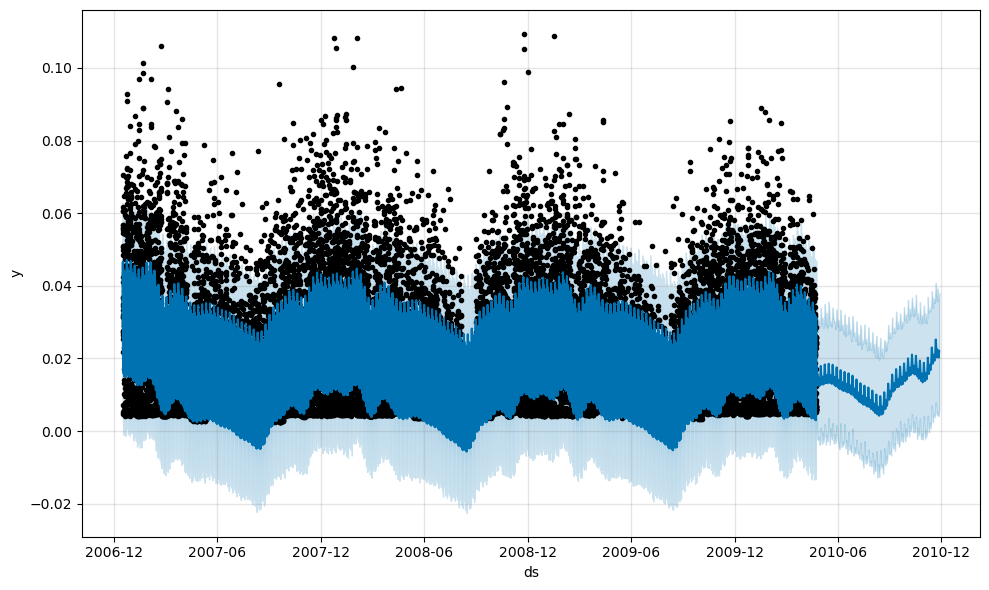

In [36]:
fig1 = m.plot(forecast)

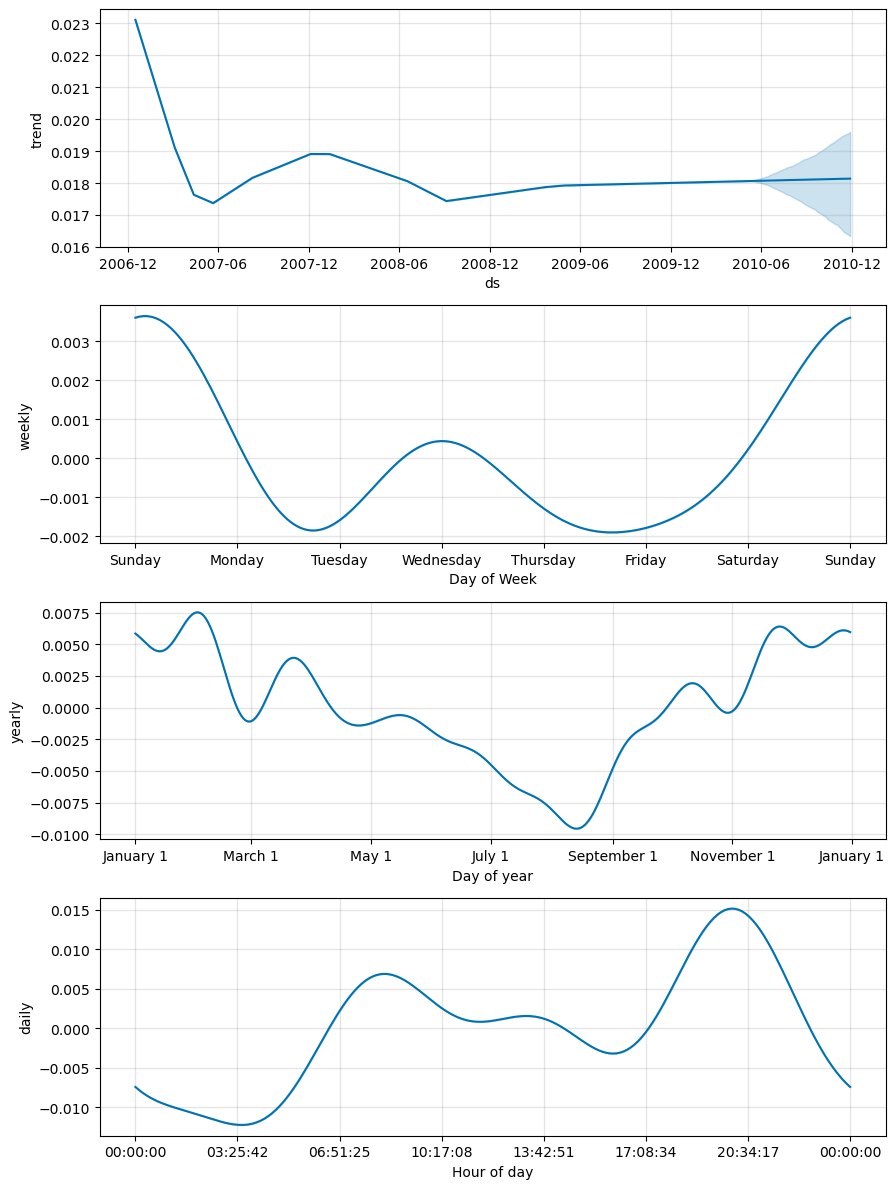

In [37]:
fig2 = m.plot_components(forecast)

In [44]:
from prophet.diagnostics import cross_validation

In [46]:
cv_days = cross_validation(m,
                         horizon='90 days',
                         period='30 days',
                         initial='810 days',
                         parallel='threads')

19:39:02 - cmdstanpy - INFO - Chain [1] start processing
19:39:02 - cmdstanpy - INFO - Chain [1] start processing
19:39:04 - cmdstanpy - INFO - Chain [1] start processing
19:39:05 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:25 - cmdstanpy - INFO - Chain [1] done processing
19:39:32 - cmdstanpy - INFO - Chain [1] done processing
19:39:46 - cmdstanpy - INFO - Chain [1] done processing
19:39:53 - cmdstanpy - INFO - Chain [1] done processing
19:39:58 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing
19:40:17 - cmdstanpy - INFO - Chain [1] start processing
19:40:30 - cmdstanpy - INFO - Chain [1] start processing
19:40:32 - cmdstanpy - INFO - Chain [1] done processing
19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1

In [48]:
from prophet.diagnostics import performance_metrics

In [49]:
cv_p = performance_metrics(cv_days)
cv_p.head(3)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.000,0.011,0.008,0.800,0.452,0.557,0.880
1,9 days 01:00:00,0.000,0.011,0.008,0.800,0.452,0.557,0.880
2,9 days 02:00:00,0.000,0.011,0.008,0.800,0.452,0.557,0.880


In [50]:
from prophet.plot import plot_cross_validation_metric

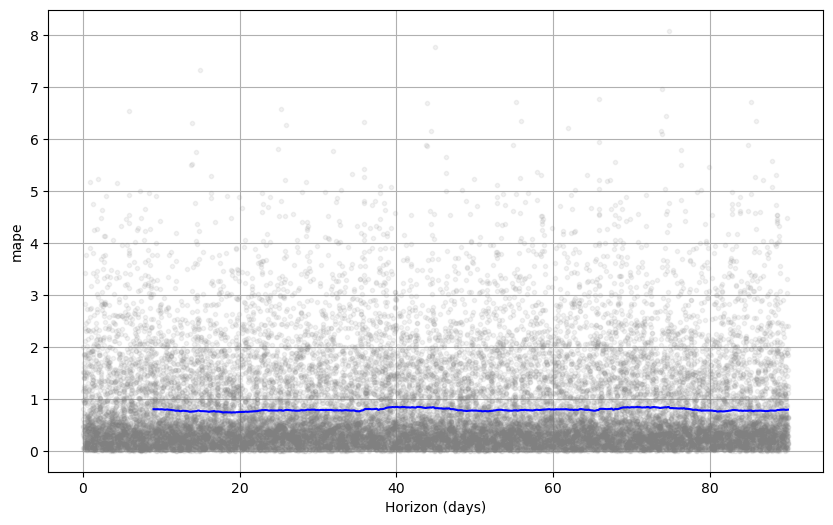

In [53]:
fig = plot_cross_validation_metric(cv_days, metric='mape')